# Eigen Solver Comparison in Pyspark

The objective of this notebook is to compare various methods of computing the eigenvalues and eigenvalues of an adjacency matrix. The eigenvalues and eigenvectors are crucial parts of EDA in graph theory. For example, the eigenvalues and eigenvectors can be used to determine different centrality measures within the graph, such as degree centrality, betweenness centrality, and eigenvector centrality. Additionally, they can help to identify important structural features of the graph, such as connected components and communities. In this notebook, we will explore several methods for computing the eigenvalues and eigenvectors of an adjacency matrix starting with numpy and scipy methods for small graphs, as well as exploring methods of implementing PySpark to scale the computation on large graphs.

The following code is essentially setting up an environment to work with a graph that is stored in a Neo4j database. 

It establishes a connection to the database, reads the vertex and edge information, and creates a graph object using GraphFrame. GraphFrame is a package that extends Apache Spark with graph computation capabilities, allowing for graph computations to be done in a distributed manner. The graph object can then be used for various graph computations, such as computing centrality measures or detecting communities within the graph.

For the sake of speed, we will be importing a quite small graph (179 nodes), from a Neo4j Server loaded with the classic Movies example.

In [ ]:
# Import necessary modules
from neo4j import GraphDatabase
from graphframes import GraphFrame
from pyspark.sql import SparkSession
from py4j.java_gateway import JavaGateway
import numpy as np
from pyspark.ml.linalg import DenseVector, SparseVector, Vectors, Matrices, VectorUDT
from pyspark.sql import Column
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, StructType, StructField, DoubleType, ArrayType, StringType
import pyspark.sql.functions as F
import time

# Set the URI, username, and password for the Neo4j database
uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'password'

# Create a SparkSession to interface with the Neo4j database
spark = SparkSession.builder.appName('eigs_solver') \
    .config('spark.jars.packages', 'org.neo4j:neo4j-connector-apache-spark_2.12:5.0.0_for_spark_3,graphframes:graphframes:0.8.0-spark3.0-s_2.12,ml.sparkling:sparkling-graph-operators_2.11:0.0.7') \
    .config('spark.neo4j.bolt.url', uri) \
    .config('spark.neo4j.bolt.user', user) \
    .config('spark.neo4j.bolt.password', password) \
    .getOrCreate()

# Query for the vertices that match the filter
vertices = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option('query','''MATCH (n)
                        RETURN id(n) as id''') \
    .load()

# Extract the vertex IDs from the DataFrame
vertex_ids = vertices.select("id").rdd.flatMap(lambda x: x).collect()

# Query for the edges that connect the specified vertices
edges = spark.read.format("org.neo4j.spark.DataSource") \
    .option("url", uri) \
    .option("authentication.basic.username", user) \
    .option("authentication.basic.password", password) \
    .option("query", """MATCH (n1) --(n2)
                        WITH id(n1) as src, id(n2) as dst
                        RETURN src, dst""") \
    .load()

# Create a GraphFrame object using the vertices and edges DataFrame
graph = GraphFrame(vertices, edges)

# Basic EDA on GraphFrame object

In [2]:
# Print the number of vertices and edges in the graph
print("Number of vertices: ", graph.vertices.count())
print("Number of edges: ", graph.edges.count())

# Print the schema of the vertices and edges DataFrames
print("Vertices schema: ")
graph.vertices.printSchema()
print("Edges schema: ")
graph.edges.printSchema()

# Show the first 10 vertices and edges in the graph
print("First 10 vertices:")
graph.vertices.show(10)
print("First 10 edges:")
graph.edges.show(10)

# Compute the degree of each vertex and show the result
degrees = graph.degrees
print("Degrees of vertices:")
degrees.show(10)

# Compute the in-degree and out-degree of each vertex and show the result
inDegrees = graph.inDegrees
outDegrees = graph.outDegrees
print("In-degrees of vertices:")
inDegrees.show(10)
print("Out-degrees of vertices:")
outDegrees.show(10)


# Compute the triangle count of the graph and show the result
tc = graph.triangleCount()
print("Triangle count:")
tc.show(10)

Number of vertices:  179
Number of edges:  516
Vertices schema: 
root
 |-- id: long (nullable = true)

Edges schema: 
root
 |-- src: long (nullable = true)
 |-- dst: long (nullable = true)

First 10 vertices:
+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+
only showing top 10 rows

First 10 edges:
+---+---+
|src|dst|
+---+---+
|  1|  0|
|  0|  1|
|  2|  0|
|  0|  2|
|  3|  0|
|  0|  3|
|  4|  0|
|  0|  4|
|  5|  0|
|  0|  5|
+---+---+
only showing top 10 rows



/Users/michaelroth/miniforge3/envs/golden_torch/lib/python3.10/site-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Degrees of vertices:


+---+------+
| id|degree|
+---+------+
|  1|    14|
|  0|    16|
|  2|     6|
|  3|     6|
|  4|    10|
|  5|    18|
|  6|    18|
|  7|    12|
|  8|     2|
|  9|    14|
+---+------+
only showing top 10 rows

In-degrees of vertices:
+---+--------+
| id|inDegree|
+---+--------+
|  0|       8|
|  1|       7|
|  2|       3|
|  3|       3|
|  4|       5|
|  5|       9|
|  6|       9|
|  7|       6|
|  8|       1|
|  9|       7|
+---+--------+
only showing top 10 rows

Out-degrees of vertices:
+---+---------+
| id|outDegree|
+---+---------+
|  1|        7|
|  0|        8|
|  2|        3|
|  3|        3|
|  4|        5|
|  5|        9|
|  6|        9|
|  7|        6|
|  8|        1|
|  9|        7|
+---+---------+
only showing top 10 rows

Triangle count:


+-----+---+
|count| id|
+-----+---+
|    0|  0|
|    0|  7|
|    0|  6|
|    0|  9|
|    0|  5|
|    0|  1|
|    0| 10|
|    0|  3|
|    0|  8|
|    0|  2|
+-----+---+
only showing top 10 rows



# Create Laplacian Matrix

Creating a Laplacian matrix is an important step in graph analysis as it can reveal insights into the structural properties of the graph. The Laplacian matrix is a symmetric matrix that encodes the relationships between the nodes of a graph by using the degree of each node and the weights of the edges connecting them. It is used to compute various graph metrics, such as the spectral properties of the graph, the number of connected components, and the conductance of the graph. Additionally, the Laplacian matrix is used in algorithms such as spectral clustering, which can be used for partitioning the graph into communities based on its structure. In summary, the Laplacian matrix provides a useful tool for analyzing the structure and properties of a graph.

In addition to providing a useful tool for analyzing the structure and properties of a graph, the Laplacian matrix is also used to compute the eigenvalues and eigenvectors of the graph. The eigenvalues and eigenvectors of the Laplacian matrix are closely related to the spectral properties of the graph, and can be used to compute various metrics such as the graph connectivity, the number of connected components, and the conductance of the graph. Moreover, the Laplacian matrix is often preferred over the adjacency matrix for eigenvalue computation, because it captures the structural properties of the graph in a more nuanced way. In particular, the Laplacian matrix takes into account the degree of each node in the graph, which can be an important factor in determining its connectivity and other properties. Additionally, the Laplacian matrix has desirable properties, such as being positive semidefinite, which makes it easier to compute the eigenvalues and eigenvectors using standard linear algebra techniques.

In [3]:
# Create a variable edge_data that contains the graph.edges data
edge_data = graph.edges

# Construct the adjacency matrix as a DataFrame
adjacency_matrix = edge_data.selectExpr("src as i", "dst as j", "1 as value") \
                            .distinct().sort('i', 'j')

# Construct the degree matrix as a DataFrame
degree_matrix = adjacency_matrix.groupby('i') \
                                .sum('value') \
                                .withColumn('j', col('i')) \
                                .select('i', 'j', 'sum(value)') \
                                .withColumnRenamed('sum(value)', 'value') \
                                .sort('i')

# Get n number of total nodes in the complete graph
n = degree_matrix.selectExpr('MAX(i) AS n').first().n

The sort_lists function takes two columns as input and returns a struct containing two array fields that represent the sorted versions of the input columns. The function is used to sort the adjacency and Laplacian matrices based on the index of their elements.

In [4]:

def sort_lists(col1, col2):
    # Create a list of tuples that pairs the elements of col1 and col2
    pairs = list(zip(col1, col2))
    
    # Sort the list of tuples by the first element of each tuple
    sorted_pairs = sorted(pairs, key=lambda x: x[0])
    
    # Unpack the sorted pairs back into separate lists
    sorted_col1, sorted_col2 = zip(*sorted_pairs)
    
    # Return the sorted columns as a struct containing two array fields
    return (sorted_col1, sorted_col2)

# Define the schema for the output of the UDF
schema = StructType([
    StructField("sorted_col1", ArrayType(IntegerType())),
    StructField("sorted_col2", ArrayType(StringType()))
])

# Register the UDF with the defined schema
udf_sort_lists = udf(sort_lists, schema)


This next code block computes the Laplacian matrix of the graph represented by the graph object by combining the adjacency matrix and degree matrix. It then groups the resulting DataFrame by the node index and aggregates the Laplacian values and adjacent nodes into arrays. Finally, it converts the DataFrame to an RDD of (node_index, SparseVector) tuples, where each SparseVector represents a row of the Laplacian matrix, and partitions the RDD into the specified number of partitions.

In [5]:
# Define the number of partitions for the RDD
num_partitions = 1

# Compute the Laplacian matrix as an RDD of (i, SparseVector) tuples
laplacian_matrix = degree_matrix.union(adjacency_matrix) \
            .withColumn("laplacian", col("value") * (F.when(col('i') == col('j'), 1).otherwise(-1))) \
            .groupBy("i") \
            .agg(F.collect_list("j").alias("j"), F.collect_list("laplacian").alias("laplacian")) \
            .withColumn('n', F.lit(n+1)) \
            .select('i', 'n', udf_sort_lists("j", "laplacian").alias("sorted")) \
            .rdd \
            .map(lambda row: (row.i, SparseVector(row.n, row.sorted[0], row.sorted[1]))).partitionBy(num_partitions)

In [6]:
laplacian_matrix.take(1)

[(0,
  SparseVector(179, {0: 8.0, 1: -1.0, 2: -1.0, 3: -1.0, 4: -1.0, 5: -1.0, 6: -1.0, 7: -1.0, 8: -1.0}))]

# Numpy vs. Scipy

For small graphs, both NumPy and SciPy are suitable libraries for computing the eigenvalues and eigenvectors of the Laplacian matrix. They provide efficient implementations of standard linear algebra algorithms, such as the power iteration method and the Lanczos algorithm, which can be used to compute the eigenvalues and eigenvectors of a matrix. NumPy and SciPy also provide functions for sorting and manipulating arrays, which can be used to further process the eigenvalues and eigenvectors, as well as functions for visualizing data, which can be used to plot the eigenvalues and compare their magnitudes.

In [7]:
def convert_to_numpy(rdd):
    num_cols = rdd.first()[1].size
    arr = np.zeros((rdd.count(), num_cols))
    for i, row in enumerate(rdd.collect()):
        arr[i, :] = row[1].toArray()
    return arr

In [8]:
example_arr = convert_to_numpy(laplacian_matrix)

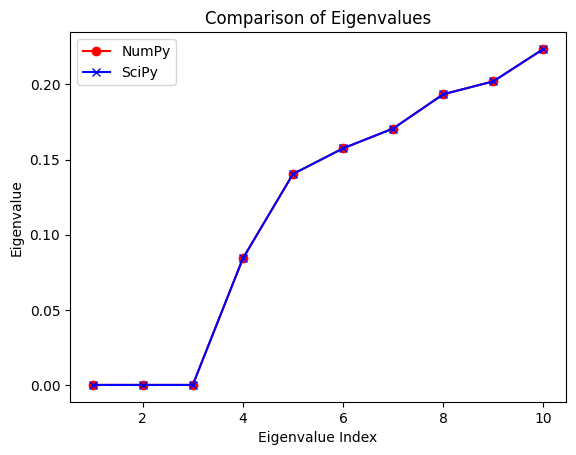

numpy time: 0.022951126098632812
scipy time: 0.022571086883544922


In [9]:
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

import time

k = 10

# assume 'laplacian_matrix_np' is your NumPy array of the Laplacian matrix
# convert it to a sparse matrix
laplacian_matrix_sparse = csr_matrix(example_arr)


# compute the eigenvalues and eigenvectors using numpy
start_np = time.time()
np_evals, np_evecs = np.linalg.eig(example_arr)
np_time = time.time() - start_np


# compute the eigenvalues and eigenvectors using scipy
start_scipy = time.time()
scipy_evals, scipy_evecs = spla.eigsh(laplacian_matrix_sparse, k=k, which='SM')
scipy_time = time.time() - start_scipy

# sort the eigenvalues in ascending order
np_evals_sorted = np.sort(np_evals)[:k]
scipy_evals_sorted = np.sort(scipy_evals)

# plot the eigenvalues
fig, ax = plt.subplots()
ax.plot(np.arange(1, k+1), np_evals_sorted, 'ro-', label='NumPy')
ax.plot(np.arange(1, k+1), scipy_evals_sorted, 'bx-', label='SciPy')
ax.legend()
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Comparison of Eigenvalues')
plt.show()

print(f'numpy time: {np_time}')

print(f'scipy time: {scipy_time}')



# Lanczos Method - Simple

The lanczos_algorithm function is an implementation of the Lanczos algorithm, which is a commonly used iterative algorithm for computing a few eigenvalues and eigenvectors of a symmetric, real-valued matrix A. This algorithm is only useful for <u>symmetric matrices of undirected graphs</u>.

The algorithm is based on generating a sequence of orthogonal vectors q1, ..., qk using a starting vector q0 and a sequence of orthogonal basis vectors v1, v2, ..., vk. The algorithm constructs a tridiagonal matrix T that is similar to A, and then computes the eigenvalues and eigenvectors of T using standard linear algebra techniques.

The function takes as input the matrix A and the number of eigenvalues and eigenvectors to compute, k. It initializes a random starting vector q, normalizes it, and then iteratively computes the basis vectors v using the Lanczos algorithm. 

The resulting tridiagonal matrix T is then computed using alpha and beta, and the eigenvalues and eigenvectors of T are computed using the eigh function from NumPy's linear algebra module.

The eigenvalues of T = eigenvalues of A, but since T is a tridiagonal matrix (consisting of one diagonal and two offset diagonals) the computation is much faster and simpler.

If you're interested in a detailed explanation of the Lanczos Method, here are some references I found helpful.

[Video lecture](https://www.youtube.com/watch?v=0t7WJybTmFg) \
[Lanczos Method - Wikipedia](https://en.wikipedia.org/wiki/Lanczos_algorithm) \
The Lanczos Method - Book by Louis Komzsik


In [10]:
def lanczos_algorithm(A, k):
    n = A.shape[0]
    q = np.random.rand(n)
    q /= np.linalg.norm(q)
    alpha = np.zeros(k)
    beta = np.zeros(k-1)
    v = np.zeros((n, k))
    v[:, 0] = q

    for j in range(k):
        w = A @ v[:, j]
        alpha[j] = np.dot(w, v[:, j])
        if j == k-1:
            break
        w -= alpha[j] * v[:, j]
        if j > 0:
            w -= beta[j-1] * v[:, j-1]
        beta[j] = np.linalg.norm(w)
        if beta[j] == 0:
            break
        v[:, j+1] = w / beta[j]

    T = np.diag(alpha) + np.diag(beta, k=1) + np.diag(beta, k=-1)
    eigvals, eigvecs = np.linalg.eigh(T)

    return eigvals, v @ eigvecs

In [11]:
l_start = time.time()
l_evals, l_evects = lanczos_algorithm(example_arr, k=179)
l_time = time.time() - l_start

In [12]:
l_evals_sorted = np.sort(l_evals)

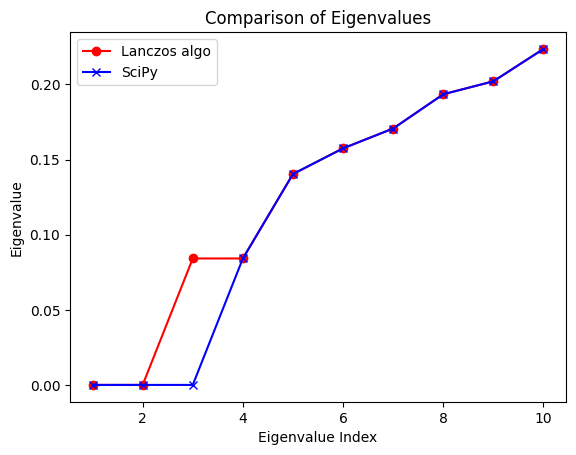

scipy time: 0.022571086883544922
lanczos time: 0.03302311897277832


In [13]:
# plot the eigenvalues
fig, ax = plt.subplots()
ax.plot(np.arange(1, k+1), l_evals_sorted[:k], 'ro-', label='Lanczos algo')
ax.plot(np.arange(1, k+1), scipy_evals_sorted, 'bx-', label='SciPy')
ax.legend()
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Comparison of Eigenvalues')
plt.show()

print(f'scipy time: {scipy_time}')
print(f'lanczos time: {l_time}')

There is an aberration in the implementation of the lanczos method in comparison to the scipy and numpy version. This could be caused by a number of factors such as the number of special cases that can modify the algorithm of the Lanczos method, such as implicit restarting, number of iterations, and other special factors or algorithms, which are not implemented in this simple version.

# Scipy COO Sparse eigsh

Unlike the previous method, which computed the Laplacian matrix as an RDD of (node_index, SparseVector) tuples and used NumPy to perform the eigenvalue decomposition, this method constructs a SciPy sparse matrix in COO format from the Laplacian matrix RDD and uses SciPy's eigsh function to compute the smallest eigenvalues and eigenvectors of the matrix.

The key difference between this method and the previous method is the way in which the Laplacian matrix is constructed and represented. The previous method used a Spark DataFrame to represent the Laplacian matrix and converted it to a NumPy array to perform the eigenvalue decomposition, while this method uses an RDD to represent the Laplacian matrix and converts it to a SciPy sparse matrix in COO format before computing the eigenvalues and eigenvectors

In [14]:
import scipy.sparse.linalg as spla
from scipy.sparse import coo_matrix
from pyspark.ml.linalg import SparseVector

# assume 'laplacian_matrix_rdd' is your RDD of the Laplacian matrix

# get the number of columns in the Laplacian matrix
num_cols = laplacian_matrix.first()[1].size

# create a sparse matrix in COO format
coo_rows = []
coo_cols = []
coo_data = []
for row_id, row in laplacian_matrix.collect():
    for col_id, val in enumerate(row):
        if val != 0:
            coo_rows.append(row_id)
            coo_cols.append(col_id)
            coo_data.append(val)
laplacian_matrix_sparse = coo_matrix(
    (coo_data, (coo_rows, coo_cols)), shape=(laplacian_matrix.count(), num_cols)
)

# compute the 10 smallest eigenvalues and eigenvectors using eigsh
num_eigvals = 10
spark_scipy_start = time.time()
eigvals, eigvecs = spla.eigsh(laplacian_matrix_sparse, k=num_eigvals, which='SM')
spark_scipy_time = time.time() - spark_scipy_start

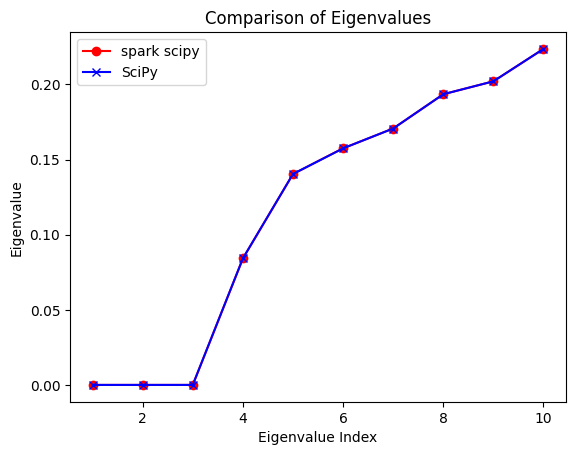

spark scipy time: 0.012088775634765625


In [15]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, k+1), eigvals, 'ro-', label='spark scipy')
ax.plot(np.arange(1, k+1), scipy_evals_sorted, 'bx-', label='SciPy')
ax.legend()
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Comparison of Eigenvalues')
plt.show()
# print(f'scipy time: {scipy_time}')
print('spark scipy time:', spark_scipy_time)

# Distributed Solver 1 - FAIL

In this section I attempted to create a distributed solver class to compute the eigenvalues.

In [16]:
from pyspark import SparkContext, SparkConf
from pyspark.mllib.linalg import SparseVector, DenseVector
from pyspark.mllib.linalg.distributed import RowMatrix
import numpy as np

class DistributedLanczosSolver:
    """
    Class for computing eigenvalues and eigenvectors of a matrix using the Lanczos method with implicit restarting in a distributed manner
    """
    def __init__(self, mat, k, num_partitions=None, restarts=3):
        """
        Constructor for DistributedLanczosSolver
        
        :param mat: Input RDD of (index, SparseVector)
        :param k: Number of eigenvalues and eigenvectors to compute
        :param num_partitions: Number of partitions to split the matrix into (optional, defaults to number of rows in matrix)
        :param restarts: Number of implicit restarts (defaults to 3)
        """
        self.mat = mat
        self.k = k
        self.num_partitions = num_partitions or mat.count()
        self.mat = self.mat.partitionBy(self.num_partitions).cache()
        self.restarts = restarts
        
    def computeEigs(self, which='L'):
        """
        Compute the eigenvalues and eigenvectors using a distributed, parallel version of the Lanczos method with implicit restarting

        :return: A tuple containing two lists: (eigenvalues, eigenvectors)
        """
        # Convert the RDD of SparseVectors to a distributed RowMatrix
        row_matrix = RowMatrix(self.mat.map(lambda x: DenseVector(np.asarray(x[1].toArray()))))
        
        
        m = self.k + self.restarts
        num_rows = self.mat.count()
        V = np.zeros((num_rows, m))
        T = np.zeros((m, m))

        # Initial Lanczos step
        v = np.random.rand(num_rows)
        v = v / np.linalg.norm(v)
        V[:, 0] = v
        w = self._multiply_row_matrix_by_vector(row_matrix, v)
        alpha = np.dot(v, w)
        T[0, 0] = alpha
        w -= alpha * v
        beta = np.linalg.norm(w)
        v = w / beta

        for j in range(self.k - 1):
            for i in range(j, m - 1):
                V[:, i + 1] = v
                w = self._multiply_row_matrix_by_vector(row_matrix, v)
                w -= beta * V[:, i]
                alpha = np.dot(v, w)
                T[i + 1, i] = T[i, i + 1] = beta
                T[i, i] = alpha
                w -= alpha * v
                beta = np.linalg.norm(w)
                v = w / beta

            # Compute the Ritz pairs of the tridiagonal matrix T
            eigvals, eigvecs = np.linalg.eigh(T[:m - 1, :m - 1])

            # Sort the Ritz pairs in descending order of eigenvalues
            if which == 'L':
                idx = np.argsort(eigvals)[::-1]
            elif which == 'S':
                idx = np.argsort(eigvals)
            else:
                raise AssertionError()
            eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

            # Update the tridiagonal matrix T and the Lanczos vectors V
            T.fill(0)
            for i, eigval in enumerate(eigvals[:self.k]):
                T[i, i] = eigval

            for i in range(self.k, m - 1):
                T[i, i + 1] = T[i + 1, i] = np.linalg.norm(eigvecs[i + 1:, i])

            eigvecs_padded = np.eye(m)
            eigvecs_padded[:m - 1, :m - 1] = eigvecs
            V = np.dot(V, eigvecs_padded)

        # Return the desired eigenvalues and eigenvectors
        return eigvals[:self.k].tolist(), V[:, :self.k].T.tolist()
    
    def _multiply_row_matrix_by_vector(self, row_matrix, vector):
        """
        Multiply a RowMatrix by a local dense vector on the right.

        :param row_matrix: A RowMatrix
        :param vector: A 1D NumPy array
        :return: A NumPy array representing the result of the multiplication
        """
        dense_vector = DenseVector(vector)
        return np.array(row_matrix.rows.map(lambda row: row.dot(dense_vector)).collect())

In [19]:
num_partitions = 1

from pyspark.mllib.linalg.distributed import IndexedRowMatrix, IndexedRow

dist_lanczos_start = time.time()
solver = DistributedLanczosSolver(
    laplacian_matrix,
    k=10,
    num_partitions=num_partitions,
    restarts=3
)
eval_sm, evect_sm = solver.computeEigs(which='S')
dist_lanczos_time = time.time() - dist_lanczos_start
print('distributed lanczos time:', dist_lanczos_time)

distributed lanczos time: 9.792415142059326


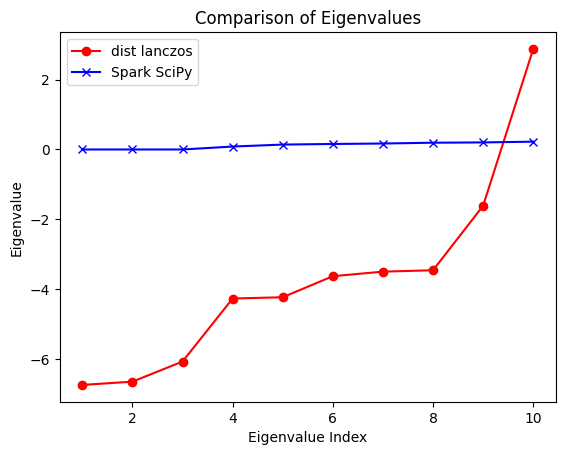

In [20]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, k+1), eval_sm[:k], 'ro-', label='dist lanczos')
ax.plot(np.arange(1, k+1), eigvals, 'bx-', label='Spark SciPy')
ax.legend()
ax.set_xlabel('Eigenvalue Index')
ax.set_ylabel('Eigenvalue')
ax.set_title('Comparison of Eigenvalues')
plt.show()

Of course, with the Lanczos method, the eigenvalue and eigenvectors extracted as only approximations of the real eigs. But it's obvious from the start that these are way off.

# Distributed Solver 2 - FAIL

The distributed_dot_product function is defined incorrectly because it tries to compute the dot product between two RDDs using a join and a map-reduce operation. This is not possible because RDDs are distributed collections and do not support dot products or other operations that require global knowledge of the data.

The distributed_lanczos function attempts to implement the Lanczos algorithm for computing eigenvalues and eigenvectors of a sparse matrix using distributed RDDs in PySpark. It initializes the algorithm with a random starting vector v1, then iteratively applies the algorithm to compute the Lanczos vectors and tridiagonal matrix T. The function then computes the eigenvalues and eigenvectors of T using eigh_tridiagonal from SciPy, and uses a linear combination of the Lanczos vectors to compute the eigenvectors of the original matrix.

However, the implementation has several issues, including the incorrect distributed_dot_product function, as well as the use of the lookup function on RDDs, which is expensive and can lead to out-of-memory errors if the RDD is too large.

While the distributed_lanczos function has the potential to compute eigenvalues and eigenvectors of a sparse matrix in a distributed manner using PySpark, it requires significant modifications and improvements to be practical and actually work.

In [22]:
import numpy as np
from scipy.linalg import eigh_tridiagonal, LinAlgError
from scipy.sparse.linalg import cg
from pyspark.ml.linalg import DenseVector

# I originally thought this was a correct implementation of a dot product, but it is not. In fact, I find it
# is very difficult to calculate the dot product between a matrix and vectors stored as RDD's without using
# the collect function

def distributed_dot_product(rdd1, rdd2, n_partitions):
    
    # Combine the two RDDs by index
    combined_rdd = rdd1.join(rdd2, numPartitions=n_partitions)

    # Compute the product of the corresponding elements
    elementwise_product = combined_rdd.map(lambda x: x[1][0] * x[1][1])

    # Sum the elementwise products to obtain the dot product
    dot_product = elementwise_product.reduce(lambda a, b: a + b)

    return dot_product

from pyspark.mllib.linalg import DenseVector, SparseVector

def distributed_lanczos(sparse_rdd, n, max_iter, tol, shift=None, mode='largest'):
    def multiply_shifted_sparse_row(row_index, sparse_vector, dense_vector, shift):
        result_value = sparse_vector.dot(dense_vector)
        if shift is not None and row_index in sparse_vector.indices:
            result_value -= shift * sparse_vector[row_index]
        return row_index, result_value

    v0 = DenseVector(np.zeros(n))
    v1 = DenseVector(np.random.rand(n))
    v1 = DenseVector(v1 / np.linalg.norm(v1))

    alpha = []
    beta = [0]

    v_k_minus_1_rdd = None
    v_k_rdd = None

    for k in range(1, max_iter + 1):
        if k == 1:
            v_k_minus_1_rdd = None
            v_k_rdd = sparse_rdd.context.parallelize(enumerate(v1)).partitionBy(n_partitions)
        else:
            v_k_minus_1_rdd = v_k_rdd
            v_k_rdd = v_k_plus_1_rdd

        if mode == 'largest' or shift is None:
            w_k_rdd = sparse_rdd.map(lambda row: multiply_shifted_sparse_row(row, v_k_rdd.lookup(row[0])[0], shift))
        elif mode == 'smallest':
            A_v_k = np.zeros(n)
            for row in sparse_rdd.collect():
                row_index, sparse_vector = row
                A_v_k[row_index] = sum(value * v_k_rdd.lookup(column_index)[0] for column_index, value in sparse_vector.items())
            try:
                w_k, _ = cg(A, A_v_k, tol=tol)
                w_k_rdd = sparse_rdd.context.parallelize(enumerate(w_k)).partitionBy(n_partitions)
            except LinAlgError:
                break

        alpha_k = distributed_dot_product(w_k_rdd, v_k_rdd, n_partitions)
        alpha.append(alpha_k)

        w_k_rdd = w_k_rdd.map(lambda x: (x[0], x[1] - alpha_k * v_k_rdd.lookup(x[0])[0] - beta[-1] * (0 if v_k_minus_1_rdd is None else v_k_minus_1_rdd.lookup(x[0])[0])))

        beta_k = w_k_rdd.map(lambda x: x[1] ** 2).sum() ** 0.5
        beta.append(beta_k)

        v_k_plus_1_rdd = w_k_rdd.map(lambda x: (x[0], x[1] / beta_k)).partitionBy(n_partitions)

        if k > 1 and abs(beta[-1]) < tol:
            break

    k = len(alpha)
    diag_T = np.array(alpha)
    off_diag_T = np.array(beta[1:k])

    eigenvalues_T, eigenvectors_T = eigh_tridiagonal(diag_T, off_diag_T)

    if mode == 'largest' and shift is not None:
        eigenvalues_A = eigenvalues_T + shift
    elif mode == 'smallest':
        eigenvalues_A = 1 / eigenvalues_T
    else:
        eigenvalues_A = eigenvalues_T

    lanczos_vectors = []
    for k in range(1, max_iter + 1):
        if k == 1:
            lanczos_vectors.append(v_k_minus_1_rdd.lookup(k - 1)[0] if v_k_minus_1_rdd is not None else np.zeros(n))
        lanczos_vectors.append(v_k_rdd.lookup(k - 1)[0])

    lanczos_vectors = np.array(lanczos_vectors)

    # Compute the eigenvectors of A using a linear combination of the Lanczos vectors
    eigenvectors_A = np.dot(lanczos_vectors.T, eigenvectors_T)

    return eigenvalues_A, eigenvectors_A



In [23]:
# distributed_lanczos(laplacian_matrix, 
#                     n = n,
#                     max_iter=10,
#                     tol=1e-8,
#                     mode='largest'
#                    )

# Distributed Solver 3 - FAIL

This is another failure case, again implementing the faulty distributed_dot_product function from before. (I didn't realize until after trying to debug this one).

In [ ]:
import numpy as np
from scipy.linalg import eigh_tridiagonal, LinAlgError
from scipy.sparse.linalg import cg
from pyspark.ml.linalg import DenseVector

sparse_rdd = laplacian_matrix
max_iter=10
tol=1e-12
shift = None
mode='smallest'
n = 179
n_partitions = 1


def distributed_matrix_vector_dot_product(rdd1, rdd2, n_partitions):
    return rdd1.context.parallelize(enumerate(distributed_dot_product(rdd1, rdd2, n_partitions)))

def distributed_matrix_vector_multiply(matrix_rdd, vector_rdd, n_partitions):
    # Multiply the matrix (in sparse format) by the vector
    result_rdd = matrix_rdd.join(vector_rdd, numPartitions=n_partitions)\
                           .map(lambda x: (x[0], x[1][0].dot(x[1][1])))\
                           .reduceByKey(lambda a, b: a + b)
    return result_rdd

def distributed_matrix_vector_multiply_shift(matrix_rdd, vector_rdd, shift, n_partitions):
    return matrix_rdd.join(vector_rdd, numPartitions=n_partitions).map(
        lambda x: (x[0], x[1][0].dot(x[1][1]) - (shift * x[1][0][x[0]]) if x[0] in x[1][0].indices else x[1][0].dot(x[1][1]))
    )

#wrong wrong wrong
def multiply_shifted_sparse_row(row, shift):
    row_index, (sparse_vector, dense_value) = row
    dense_vector = [dense_value] * sparse_vector.size
    result_value = sparse_vector.dot(dense_vector)
    if shift is not None and row_index in sparse_vector.indices:
        result_value -= shift * sparse_vector[row_index]
    return row_index, result_value



def power_iteration(matrix_rdd, initial_vector_rdd, n_iterations, n_partitions):
    current_vector_rdd = initial_vector_rdd
    for _ in range(n_iterations):
        # Multiply the matrix by the current vector
        next_vector_rdd = distributed_matrix_vector_dot_product(matrix_rdd, current_vector_rdd, n_partitions)

        # Normalize the result
        norm = next_vector_rdd.map(lambda x: x[1] ** 2).sum() ** 0.5
        current_vector_rdd = next_vector_rdd.map(lambda x: (x[0], x[1] / norm))
    return current_vector_rdd

def rayleigh_quotient_iteration(matrix_rdd, initial_vector_rdd, n_iterations):
    current_vector_rdd = initial_vector_rdd
    for _ in range(n_iterations):
        # Multiply the matrix by the current vector
        next_vector_rdd = distributed_matrix_vector_dot_product(matrix_rdd, current_vector_rdd, n_partitions)
        
        # Compute the Rayleigh quotient (largest eigenvalue estimate)
        numerator = distributed_dot_product(next_vector_rdd, current_vector_rdd, n_partitions)
        denominator = distributed_dot_product(current_vector_rdd, current_vector_rdd, n_partitions)
        rayleigh_quotient = numerator / denominator
        
        # Normalize the result
        norm = next_vector_rdd.map(lambda x: x[1] ** 2).sum() ** 0.5
        current_vector_rdd = next_vector_rdd.map(lambda x: (x[0], x[1] / norm))

    return rayleigh_quotient

# Initialize the necessary variables
v0 = DenseVector(np.zeros(n))
v1 = DenseVector(np.random.rand(n))
v1 = DenseVector(v1 / np.linalg.norm(v1))

# Estimate the largest eigenvalue using Rayleigh quotient iteration
# initial_vector_rdd = sparse_rdd.context.parallelize(enumerate(v1.array))
# shift = rayleigh_quotient_iteration(sparse_rdd, initial_vector_rdd, n_iterations=10)

alpha = []
beta = [0]

v_k_rdd = None

for k in range(1, max_iter + 1):
    if k == 1:
        v_k_rdd = sparse_rdd.map(lambda row: (row[0], (row[1].dot(v1.array), None, None)))
    else:
        v_k_rdd = v_k_rdd.map(lambda x: (x[0], (x[1][1], None, x[1][0])))
        

    # Apply the matrix A (shifted or inverted) to the current Lanczos vector v_k
    if mode == 'largest' or shift is None:
        w_k_rdd = distributed_matrix_vector_multiply_shift(sparse_rdd, v_k_rdd.map(lambda x: (x[0], x[1][0])), shift, n_partitions)
    elif mode == 'smallest':
        print('smallest')
        A_v_k_rdd = distributed_matrix_vector_dot_product(sparse_rdd, v_k_rdd.map(lambda x: (x[0], x[1][0])), n_partitions)

        # Approximate the solution of the linear system A * x = A * v_k using the Power Iteration method
        w_k_rdd = power_iteration(sparse_rdd, A_v_k_rdd, n_iterations=10, n_partitions=n_partitions)

    # Calculate the diagonal element alpha_k
    alpha_k = distributed_dot_product(w_k_rdd, v_k_rdd.map(lambda x: (x[0], x[1][0])), n_partitions)
    alpha.append(alpha_k)

    # Subtract the alpha_k term and the previous Lanczos vector's contribution
    w_k_rdd = w_k_rdd.join(v_k_rdd).map(lambda row: (row[0], row[1][0] - alpha_k * row[1][1][0] - beta[-1] * (0 if row[1][1][2] is None else row[1][1][2])))

    # Calculate the off-diagonal element beta_k
    beta_k = w_k_rdd.map(lambda x: x[1] ** 2).sum() ** 0.5
    beta.append(beta_k)

    # Normalize the next Lanczos vector
    v_k_rdd = v_k_rdd.join(w_k_rdd).map(lambda x: (x[0], (x[1][0][0], x[1][1] / beta_k, x[1][0][2])))

    print(f'k: {k}, beta: {beta}, tol: {tol}')

    # Check for convergence
    if k > 1 and abs(beta[-1]) < tol:
        print('yes')
        break
                
# Form the tridiagonal matrix T using the calculated alpha and beta values
k = len(alpha)
diag_T = np.array(alpha)
off_diag_T = np.array(beta[1:k])

# Compute the eigenvalues and eigenvectors of the tridiagonal matrix T
eigenvalues_T, eigenvectors_T = eigh_tridiagonal(diag_T, off_diag_T)

# Reverse the shift for the eigenvalues if necessary
if mode == 'largest' and shift is not None:
    eigenvalues_A = eigenvalues_T + shift
elif mode == 'smallest':
    eigenvalues_A = 1 / eigenvalues_T
else:
    eigenvalues_A = eigenvalues_T

# Collect the Lanczos vectors from RDDs to local arrays
lanczos_vectors = []
for k in range(1, len(alpha)):
    if k == 1:
        lanczos_vector = np.zeros(n) if v_k_rdd.lookup(0)[0][2] is None else [v_k_rdd.lookup(0)[0][2]]
        lanczos_vectors.append(lanczos_vector)
    lanczos_vectors.append(np.array([v_k_rdd.lookup(k - 1)[0][0]]))

lanczos_vectors = np.array(lanczos_vectors)

# Compute the eigenvectors of A using a linear combination of the Lanczos vectors
eigenvectors_A = np.dot(lanczos_vectors.T, eigenvectors_T)

# Final Distributed Solver Attempt - Too Slow

This code agasin implements a distributed Lanczos method for computing a subset of eigenvalues and eigenvectors and  starts by initializing a random vector and iterating over k steps to create a tridiagonal matrix T using alpha and beta values computed at each step. Finally, it computes the eigenvalues and eigenvectors of T using the eigh_tridiagonal function.

The main bottleneck in this code is the collect() function, which is used to obtain a local copy of RDD data for subsequent processing. The use of dense vectors for the Lanczos vectors can also cause memory issues for large graphs. As a result, this code may work for small graphs and a small subset of eigenvalues, but may hit serious bottlenecks for larger graphs and a larger number of eigenvalues.

In [25]:
from pyspark.ml.linalg import Vectors
from scipy.linalg import eigh_tridiagonal

def distributed_lanczos_method(A_rdd, k, tol=1e-15):
    
    n = A_rdd.map(lambda x: x[1].size).first()
    q = DenseVector(DenseVector(np.random.rand(n)))
    q = DenseVector(q / np.linalg.norm(q))
    alpha = []
    beta = []
    v = q
    
    for j in range(k):


        if j == 0:
            v_rdd = A_rdd.context.parallelize(enumerate(v.array))
            # structure v to contain (j, j+1, j-1)
            v_rdd = v_rdd.map(lambda x: (x[0], (x[1], None, None)))
            #         w_rdd = A_rdd.map(lambda x: (x[0], x[1].dot(Vectors.sparse(x[1].size, x[1].indices, v[x[1].indices])))) # or just v instead of Sparse Vector
            w_rdd = A_rdd.map(lambda x: (x[0], x[1].dot(v.array)))
        else:
            #reposition the arrays in v from (j, j+1, j-1)
            v_rdd = v_rdd.map(lambda x: (x[0], (x[1][1], None, x[1][0])))
            v_array =  v_rdd.map(lambda x: x[1][0]).collect()
            w_rdd = A_rdd.map(lambda x: (x[0], x[1].dot(v_array)))
            

        alpha.append(DenseVector(w_rdd.map(lambda x: x[1]).collect()).dot(v_rdd.map(lambda x: x[1][0]).collect())) 
        if j == k-1:
            break
        
        w_rdd = w_rdd.join(v_rdd.map(lambda x: (x[0], x[1][0] * alpha[-1]))).map(lambda x: (x[0], x[1][0] - x[1][1]))
        if j > 0:
            w_rdd = w_rdd.join(v_rdd.map(lambda x: (x[0], x[1][2] * beta[-1]))).map(lambda x: (x[0], x[1][0] - x[1][1]))
        
        # must be way to get norm without collect???
        beta.append(np.linalg.norm(w_rdd.map(lambda x: x[1]).collect()))
        if beta[-1] < tol:
            break
        v_rdd = v_rdd.join(w_rdd.map(lambda x: (x[0], x[1] / beta[-1]))).map(lambda x: (x[0], (x[1][0][0], x[1][1], x[1][0][2])))
        
    evals_T, evecs_T = eigh_tridiagonal(alpha, beta)    
    
    return evals_T, evecs_T
    

In [29]:
evals_t, evecs_t = distributed_lanczos_method(sparse_rdd, 4)

Exception in thread "serve RDD 4641" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:535)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [30]:
evals_t

array([-6.02441283,  0.02808696,  3.26880186, 11.07734853])

Of course it may output eigenvalues, but there is no way to know the accucracy without getting all eigenvalues and sorting by size. There are other methods for extracting the smallest and largest eigenvalues from the start that are not implemented in this simple version.

# Summary

In this notebook, we have explored different implementations of the Lanczos algorithm for computing the eigenvalues and eigenvectors of large sparse matrices in a distributed setting using PySpark. We have encountered various issues and failures along the way, such as faulty dot product functions, memory errors, and slow convergence rates, which have highlighted the challenges of distributed computing. Despite these challenges, we have also seen partly successful implementations that were able to compute a subset of eigenvalues for these small graphs, showing the potential of distributed Lanczos methods for scalable matrix computation. Overall, this notebook has provided valuable insights and lessons learned for me and anyone interested in distributed computing or large-scale matrix computation.

I look forward to trying more versions of algorithm by correctly implementing the syntax and methods of PySpark. Mostly, I need to understand the best practices for matrix multiplication of data stored in pyspark clusters.